<a href="https://colab.research.google.com/github/stonehenge0/AI-verstehen-Winteraka-2024-25/blob/main/H%C3%A4lfte%202/Superposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Setup (don't read, just run!)


In [30]:
# try:
#     import google.colab # type: ignore
#     IN_COLAB = True
# except:
#     IN_COLAB = False

import os, sys
chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"

# if IN_COLAB:
#     # Install packages
#     %pip install jaxtyping
#     %pip install transformer_lens
#     %pip install git+https://github.com/callummcdougall/eindex.git

#     # Code to download the necessary files (e.g. solutions, test funcs)
#     if not os.path.exists(f"/content/{chapter}"):
#         !wget https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/main.zip
#         !unzip /content/main.zip 'ARENA_3.0-main/chapter1_transformer_interp/exercises/*'
#         sys.path.append(f"/content/{repo}-main/{chapter}/exercises")
#         os.remove("/content/main.zip")
#         os.rename(f"{repo}-main/{chapter}", chapter)
#         os.rmdir(f"{repo}-main")
#         os.chdir(f"{chapter}/exercises")
# else:
#     raise Exception("If running from VSCode, you should copy code from the Streamlit page, not the Colab.")

In [31]:
import sys
from dataclasses import dataclass
from pathlib import Path
from typing import Callable, Literal
import einops
import numpy as np
import torch as t
from jaxtyping import Float
from torch import Tensor, nn
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from tqdm.auto import tqdm
from IPython.display import display, HTML

# Make sure exercises are in the path
exercises_dir = Path(f"../../../ARENA_3.0/{chapter}/exercises").resolve()
section_dir = (exercises_dir / "part31_superposition_and_saes").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))
print(exercises_dir)

import part31_superposition_and_saes.utils as utils
import part31_superposition_and_saes.tests as tests
from plotly.express import line, imshow

device = t.device("cuda" if t.cuda.is_available() else "cpu")

/home/ferri/Daten/Studium/CdE-WA-Machine-Learning/ARENA_3.0/chapter1_transformer_interp/exercises


# 1️⃣ TMS: Superposition in a Nonprivileged Basis

## Toy Model setup

In this section, we'll be examining & running experiments on the toy model studied in [Anthropic's paper](https://transformer-circuits.pub/2022/toy_model/index.html).

You can follow along with the paper from the [Demonstrating Superposition](https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating) section onwards; it will approximately follow the order of the sections in this notebook.

This paper presented a very rudimentary model for **bottleneck superposition** - when you try and represent more than $n$ features in a vector space of dimension $n$. The model is as follows:

* We take a 5-dimensional input $x$
* We map it down into 2D space
* We map it back up into 5D space (using the transpose of the first matrix)
* We add a bias and ReLU

$$
\begin{aligned}
h &= W x \\
x' &= \operatorname{ReLU}(W^T h + b)
\end{aligned}
$$

### What's the motivation for this setup?

The input $x$ represents our five features (they're uniformly sampled between 0 and 1).

Each feature can have **importance** and **sparsity**. Recall our earlier definitions:

* **Importance** = how useful is this feature for achieving lower loss?
* **Sparsity** = how frequently is it in the input data?

This is realised in our toy model as follows:

* **Importance** = the coefficient on the weighted mean squared error between the input and output, which we use for training the model
    * In other words, our loss function is $L = \sum_x \sum_i I_i (x_i - x_i^\prime)^2$, where $I_i$ is the importance of feature $i$.
* **Sparsity** = the probability of the corresponding element in $x$ being zero
    * In other words, this affects the way our training data is generated (see the method `generate_batch` in the `Module` class below)
    * We often refer to **feature probability** (1 minus sparsity) rather than sparsity

The justification for using $W^T W$ is as follows: we can think of $W$ (which is a matrix of shape `(2, 5)`) as a grid of "overlap values" between the features and bottleneck dimensions. The values of the 5x5 matrix $W^T W$ are the dot products between the 2D representations of each pair of features. To make this intuition clearer, imagine each of the columns of $W$ were unit vectors, then $W^T W$ would be a matrix of cosine similarities between the features (with diagonal elements equal to 1, because the similarity of a feature with itself is 1). To see this for yourself:


In [32]:
t.manual_seed(2)

W = t.randn(2, 5)
W_normed = W / W.norm(dim=0, keepdim=True)

imshow(W_normed.T @ W_normed, title="Cosine similarities of each pair of 2D feature embeddings", width=600)

To put it another way - if the columns of $W$ were orthogonal, then $W^T W$ would be the identity. This can't actually be the case because $W$ is a 2x5 matrix, but its columns can be "nearly orthgonal" in the sense of having pairwise cosine similarities close to 0.

<details>
<summary>

Question - can you prove that $W^T W$ can't be the identity when $W$ is not a square matrix?
</summary>

Proof #1: the rank of a matrix product $AB$ is upper-bounded by the maximum of the two factors $A$ and $B$. In the case of $W^T W$, both matrices have rank at most 2, so the product has rank at most 2.

Proof #2: for any vector $x$, $W^T W x = W^T (Wx)$ is in the span of the columns of $W^T$, which is vector space with rank 2.

</details>


Another nice thing about using two bottleneck dimensions is that we get to visualise our output! We've got a few helper functions for this purpose.


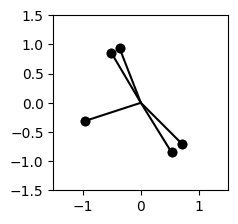

In [33]:
utils.plot_features_in_2d(
    W_normed.unsqueeze(0), # shape [instances=1 d_hidden=2 features=5]
)

Compare this plot to the `imshow` plot above, and make sure you understand what's going on here (and how the two plots relate to each other). A lot of the subsequent exercises run with this idea of a geometric interpretation of the model's features and bottleneck dimensions.

<details>
<summary>Help - I'm confused about how these plots work.</summary>

As mentioned, you can view $W$ as being a set of five 2D vectors, one for each of our five features. The heatmap shows us the cosine similarities between each pair of these vectors, and the second plot shows us these five vectors in 2D space.

In the example above, we can see two pairs of vectors (the 1st & 2nd, and the 0th & 4th) have very high cosine similarity. This is reflected in the 2D plot, where these features are very close to each other (the 0th feature is the darkest color, the 4th feature is the lightest).

</details>

### Defining our model

Below is some code for your model (with most methods not filled out yet). It should be familiar to you if you've already built simple neural networks earlier in this course.

Some notes on the initialization method, which is filled out for you:

#### Weights & instances

The `Config` class has an `n_inst` class. This is so we can optimize multiple models at once in a single training loop (this'll be useful later on). You should treat this as basically like a batch dimension for your weights: each of your weights/biases will actually be `n_inst` separate weights/biases stacked along the zeroth dimension, and each of these will be trained independently, on different data, in parallel (using the same optimizer).

We initialize weights `W` and `b_final`, which correspond to $W$ and $b$ in the Anthropic paper.

#### Feature probability and sparsity

The `feature_probability` and `importance` arguments correspond to sparsity and importance of features.

We have the relation  `feature_probability = 1 - sparsity`. We'll usually refer to the feature probability rather than the sparsity, since this is easier. We'll often be dealing with very small values $p = 1 - S \approx 0$. The feature probability is used to generate our training data; the importance is used in our loss function (see later for both of these). The default is `feature_probability = None`, which means $p = 1$ (no sparsity).

The `importance` argument is used when calculating loss (see later exercise). The default is `importance = None` which results in uniform importance.

In the `__init__` method, we have code to broadcast `feature_probability` and `importance`, so that by the end they both always have shape `(n_inst, n_features)`.

### Exercise - implement `forward`

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-20 minutes on this exercise.
```

For now, you just need to fill in the `forward` method. As the exercises go on, you'll fill in some more of these functions, but for now you can ignore the others.

In [34]:
def linear_lr(step, steps):
    return (1 - (step / steps))

def constant_lr(*_):
    return 1.0

def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))


@dataclass
class Config:
    # We optimize n_inst models in a single training loop to let us sweep over sparsity or importance
    # curves efficiently. You should treat the number of instances `n_inst` like a batch dimension,
    # but one which is built into our training setup. Ignore the latter 3 arguments for now, they'll
    # return in later exercises.
    n_inst: int
    n_features: int = 5
    d_hidden: int = 2
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0
    feat_mag_distn: Literal["unif", "jump"] = "unif"


class Model(nn.Module):
    W: Float[Tensor, "inst d_hidden feats"]
    b_final: Float[Tensor, "inst feats"]

    # Our linear map (for a single instance) is x -> ReLU(W.T @ W @ x + b_final)

    def __init__(
        self,
        cfg: Config,
        feature_probability: float | Tensor = 0.01,
        importance: float | Tensor = 1.0,
        device=device,
    ):
        super(Model, self).__init__()
        self.cfg = cfg

        if isinstance(feature_probability, float):
            feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to(
            (cfg.n_inst, cfg.n_features)
        )
        if isinstance(importance, float):
            importance = t.tensor(importance)
        self.importance = importance.to(device).broadcast_to((cfg.n_inst, cfg.n_features))

        self.W = nn.Parameter(
            nn.init.xavier_normal_(t.empty((cfg.n_inst, cfg.d_hidden, cfg.n_features)))
        )
        self.b_final = nn.Parameter(t.zeros((cfg.n_inst, cfg.n_features)))
        self.to(device)


    def forward(
        self,
        features: Float[Tensor, "... inst feats"],
    ) -> Float[Tensor, "... inst feats"]:
        # YOUR CODE HERE
        A = einops.einsum(self.W, self.W, "inst d_hidden feats_in, inst d_hidden feats_out -> inst feats_in feats_out")
        return t.relu(einops.einsum(A, features, "inst feats_in feats_out, ... inst feats_in -> ... inst feats_out") + self.b_final)


    def generate_batch(self, batch_size) -> Float[Tensor, "batch inst feats"]:
        """
        Generates a batch of data.
        """
        # You'll fill this in later
        repeated_probs = einops.repeat(self.feature_probability, "... -> b ...", b = batch_size)
        return t.bernoulli(repeated_probs) * t.rand(repeated_probs.shape)


    def calculate_loss(
        self,
        out: Float[Tensor, "batch inst feats"],
        batch: Float[Tensor, "batch inst feats"],
    ) -> Float[Tensor, ""]:
        """
        Calculates the loss for a given batch (as a scalar tensor), using this loss described in the
        Toy Models of Superposition paper:

            https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

        Note, `self.importance` is guaranteed to broadcast with the shape of `out` and `batch`.
        """
        # You'll fill this in later
        return t.sum ((out - batch)**2 * self.importance) / (out.shape[0] * out.shape[2])


    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 50,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        """
        Optimizes the model using the given hyperparameters.
        """
        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))

        for step in progress_bar:
            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group["lr"] = step_lr

            # Optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=loss.item() / self.cfg.n_inst, lr=step_lr)


tests.test_model(Model)

All tests in `test_model` passed!


### Exercise - implement `generate_batch`

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-15 minutes on this exercise.
```

Next, you should implement the function `generate_batch` above. This should return a tensor of shape `(n_batch, instances, features)`, where:

* The `instances` and `features` values are taken from the model config,
* Each feature is present with probability `self.feature_probability`,
* For each present feature, its **magnitude** is sampled from a uniform distribution between 0 and 1.

Make sure you understand this function well (we recommend looking at the solutions even after you pass the tests), because we'll be making more complicated versions of this function in the section on correlations.

Remember, you can assume `model.feature_probability` has shape `(n_inst, n_features)`.

When you've implemented this function, run the code below to test it.

In [35]:
tests.test_generate_batch(Model)

All tests in `test_generate_batch` passed!


## Training our model


The details of training aren't very conceptually important, so we've given you most of the code to train the model below. We use **learning rate schedulers** to control the learning rate as the model trains - you'll use this later on during the RL chapter.

### Exercise - implement `calculate_loss`

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 5-10 minutes on this exercise.
```

You should fill in the `calculate_loss` function below. The loss function **for a single instance** is given by:

$$
L=\frac{1}{BF}\sum_x \sum_i I_i\left(x_i-x_i^{\prime}\right)^2
$$

where:

* $B$ is the batch size,
* $F$ is the number of features,
* $x_i$ are the inputs and $x_i'$ are the model's outputs,
* $I_i$ is the importance of feature $i$,
* $\sum_i$ is a sum over features,
* $\sum_x$ is a sum over the elements in the batch.

For the general case, we sum this formula over all instances.

<details>
<summary>Question - why do you think we take the mean over the feature and batch dimensions, but we sum over the instances dimension?</summary>

We take the mean over batch size because this is standard for loss functions (and means we don't have to use a different learning rate for different batch sizes).

We take the mean over the feature dimension because that's [normal for MSE loss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html).

We sum over the instances dimension because we want to train each instance independently, and at the same rate as we would train a single instance.

</details>

In [36]:
tests.test_calculate_loss(Model)

All tests in `test_calculate_loss` passed!


Now, we'll reproduce a version of the figure from the introduction, although with a slightly different version of the code.

A few notes:

* The `importance` argument is the same for all instances. It takes values between 1 and ~0.66 for each feature (so for every instance, there will be some features which are more important than others).
* The `feature_probability` is the same for all features, but it varies across instances. In other words, we're runnning several different experiments at once, and we can compare the effect of having larger feature sparsity in these experiments.


In [37]:
cfg = Config(n_inst=8, n_features=5, d_hidden=2)

# importance varies within features for each instance
importance = (0.9 ** t.arange(cfg.n_features))

# sparsity is the same for all features in a given instance, but varies over instances
feature_probability = (50 ** -t.linspace(0, 1, cfg.n_inst))

line(importance, width=600, height=400, title="Importance of each feature (same over all instances)", labels={"y": "Feature importance", "x": "Feature"})
line(feature_probability, width=600, height=400, title="Feature probability (varied over instances)", labels={"y": "Probability", "x": "Instance"})

In [38]:
model = Model(
    cfg=cfg,
    device=device,
    importance=importance[None, :],
    feature_probability=feature_probability[:, None],
)
model.optimize(steps=10_000)

  0%|          | 0/10000 [00:00<?, ?it/s]

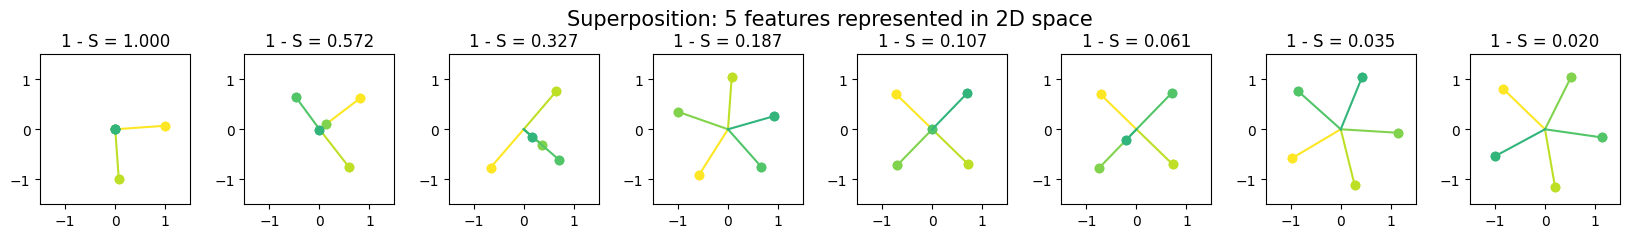

In [39]:
utils.plot_features_in_2d(
    model.W,
    colors=model.importance,
    title=f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles=[f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

<details>
<summary>Click this dropdown to see what you should be getting from this visualisation.</summary>

<br>
<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/sp1.png" width="1400">

</details>

### Exercise - interpret these diagrams

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵🔵⚪

You should spend up to 10-20 minutes on this exercise.
```

Remember that for all these diagrams, the darker colors have lower importance and the lighter colors have higher importance. Also, the sparsity of all features is increasing as we move from left to right (at the far left there is no sparsity, at the far right feature probability is 5% for all features, i.e. sparsity of 95%).

<details>
<summary>Hint</summary>

For low sparsity, think about what the model would learn to do if all 5 features were present all the time. What's the best our model could do in this case, and how does that relate to the **importance** values?

For high sparsity, think about what the model would learn to do if there was always exactly one feature present. Does this make interference between features less of a problem?
</details>

<details>
<summary>Answer (intuitive)</summary>

When there is no sparsity, the model can never represent more than 2 features faithfully, so it makes sense for it to only represent the two most important features. It stores them orthogonally in 2D space, and sets the other 3 features to zero. This way, it can reconstruct these two features perfectly, and ignores all the rest.

When there is high sparsity, we get a pentagon structure. Most of the time at most one of these five features will be active, which helps avoid **interference** between features. When we try to recover our initial features by projecting our point in 2D space onto these five directions, most of the time when feature $i$ is present, we can be confident that our projection onto the $i$-th feature direction only captures this feature, rather than being affected by the presence of other features. We omit the mathematical details here.

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/download (7).png" width="900">

The key idea here is that two forces are competing in our model: **feature benefit** (representing more thing is good!), and **interference** (representing things non-orthogonally is bad). The higher the sparsity, the more we can reduce the negative impact of interference, and so the trade-off skews towards "represent more features, non-orthogonally".

</details>


We can also generate a batch and visualise its embedding. Most interestingly, you should see that in the plots with high sparsity (to the right), we very rarely have interference between the five features, because most often $\leq 1$ of those features is present, and the model can recover it by projecting along the corresponding feature dimension without losing any information.

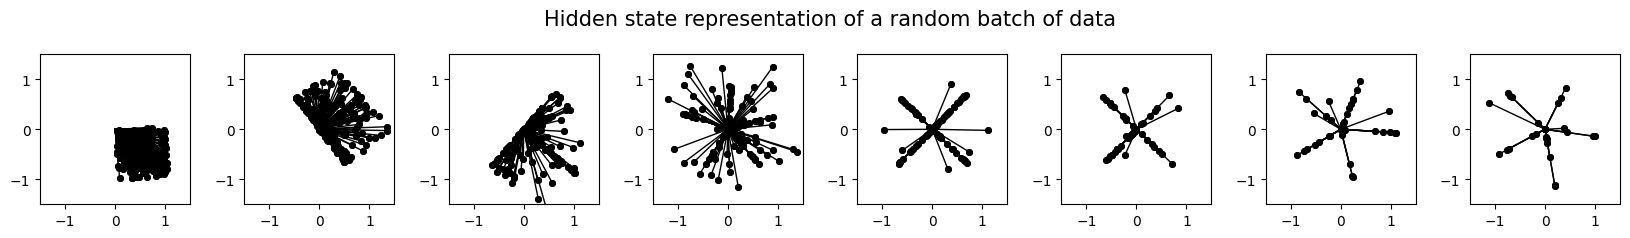

In [40]:
with t.inference_mode():
    batch = model.generate_batch(200)
    hidden = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> instances hidden batch_size")

utils.plot_features_in_2d(hidden, title = "Hidden state representation of a random batch of data")

<details>
<summary>Click this dropdown to see what you should be getting from this visualisation.</summary>

<br>
<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/hs1.png" width="1400">

</details>

## Visualizing features across varying sparsity


Now that we've got our pentagon plots and started to get geometric intuition for what's going on, let's scale things up! We're now operating in dimensions too large to visualise, but hopefully our intuitions will carry over.


In [41]:
cfg = Config(n_inst=10, n_features=100, d_hidden=20)

importance = 100 ** -t.linspace(0, 1, cfg.n_features)
feature_probability = 20 ** -t.linspace(0, 1, cfg.n_inst)

line(importance, width=600, height=400, title="Importance of each feature (same over all instances)", labels={"y": "Feature importance", "x": "Feature"})
line(feature_probability, width=600, height=400, title="Feature probability (varied over instances)", labels={"y": "Probability", "x": "Instance"})

In [ ]:
model = Model(
    cfg=cfg,
    device=device,
    importance=importance[None, :],
    feature_probability=feature_probability[:, None],
)
model.optimize(steps=10_000)

  0%|          | 0/10000 [00:00<?, ?it/s]

Because we can't plot features in 2D anymore, we're going to use a different kind of visualisation:

* The **bottom row plots** shows a bar graph of all the features and their corresponding embedding norms $||W_i||$.
    * As we increase sparsity, the model is able to represent more features (i.e. we have more features with embedding norms close to 1).
    * We also color the bars according to whether they're orthogonal to other features (purple) or not (yellow). So we can see that for low sparsity most features are represented orthogonally (like our left-most plots above) but as we increase sparsity we transition to all features being represented non-orthogonally (like our right-most pentagon plots above).
* The **top row plots** show us the dot products between all pairs of feature vectors (kinda like the heatmaps we plotted at the start of this section).
    * This is another way of visualising the increasing interference between features as we increase sparsity.
    * Note that all these right hand plots represent **matrices with rank at most `d_hidden=20`**. The first few are approximately submatrices of the identity (because we perfectly reconstruct 20 features and delete the rest), but the later plots start to display inference as we plot more than 20 values (the diagonals of these matrices have more than 20 non-zero elements).

See the section [Basic Results](https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-basic-results) for more of an explanation of this graph and what you should interpret from it.

In [ ]:
utils.plot_features_in_Nd(
    model.W,
    height=800,
    width=1600,
    title="ReLU output model: n_features = 80, d_hidden = 20, I<sub>i</sub> = 0.9<sup>i</sup>",
    subplot_titles=[f"Feature prob = {i:.3f}" for i in feature_probability],
)

## Bonus - varying feature probability across features

In this section, we've only discussed varying feature probability across instances, and so most of the learned solutions have had uniformity (e.g. a uniform pentagon, or a uniform digon with one feature collapsed). But there's also a large set of non-uniform patterns which can be learned by our models. See the [corresponding section](https://transformer-circuits.pub/2022/toy_model/index.html#geometry-non-uniform) of the Anthropic paper, where they discuss in more detail what happens when a feature's importance is perturbed. Can you reproduce this result? Can you think of a setup which would result in a learned solution where all 5 features are represented, but two features are represented with very high cosine similarity? (You might want to return to this question at the end of the next section!).

In [ ]:
# YOUR CODE HERE - replicate Anthropic's peturbing results (optional)

# See the solutions Colab or Streamlit page for replication

# 2️⃣ TMS: Correlated / Anticorrelated Features

## Superposition with correlation

One major thing we haven't considered in our experiments is **correlation**. We could guess that superposition is even more common when features are **anticorrelated** (for a similar reason as why it's more common when features are sparse). Most real-world features are anticorrelated (e.g. the feature "this is a sorted Python list" and "this is some text in an edgy teen vampire romance novel" are probably anticorrelated - that is, unless you've been reading some pretty weird fanfics).

In this section, you'll define a new data-generating function for correlated features, and run the same experiments as in the first section.


### Exercise - implement `generate_correlated_batch`

```c
Difficulty: 🔴🔴🔴🔴⚪
Importance: 🔵🔵⚪⚪⚪

You should spend up to 20-40 minutes on this exercise.

The exercise itself is not conceptually important, and it is a bit fiddly / delicate, so you should definitely look at the
solutions if you get stuck. Understanding the results and why they occur is more important than the implementation!
```

You should now fill in the three methods `generate_correlated_features`, `generate_anticorrelated_features` and `generate_uncorrelated_features` in the `Model` class, which are created to generate correlated / anticorrelated data. We've given you a new `generate_batch` function which returns the aggregation from all of these methods.

Note, in the correlated & anticorrelated cases you can assume that the feature probability is the same for all features in each instance. We start these functions by asserting this for you, and creating a vector `p` which contains this feature probability for each instance (which is what you should use instead of `model.feature_probability`). The same is also true for the uncorrelated case, when the number of uncorrelated features we're generating is less than `cfg.n_features` (since if not, it's fine to use the full `self.feature_probability` tensor).

You'll also need to be careful with your probabilities in the anticorrelated case. For example, if you do the following for your pair of features 1 & 2:

```python
feat1_is_present = t.rand() < p
feat2_is_present = t.rand() < p & ~feat1_is_present
```

then your `feat2` probability will actually be `p * (1 - p)` rather than the intended `p`. You want to try and make both features have probability `p`, while _also_ ensuring that they are never both active at the same time! The hints provide some guidance on how you can implement this (it's a bit fiddly and not very conceptually important!).

For more details, you can read the [experimental details in Anthropic's paper](https://transformer-circuits.pub/2022/toy_model/index.html#geometry-correlated-setup), where they describe how they setup correlated and anticorrelated sets.

<details>
<summary>Help - I'm confused about how to implement the correlated features function.</summary>

Try first creating a boolean mask of shape `(batch_size, n_inst, n_correlated_pairs)` representing whether the pair is present, then repeating that mask across feature pairs with `einops.repeat`.

</details>

<details>
<summary>Help - I'm confused about how to implement the anticorrelated features function.</summary>

Here are 2 suggested methods:

1. Create a boolean mask of shape `(batch_size, n_inst, n_anticorrelated_pairs)` with probability $2p$, which represents whether *either* feature is present - and where true, we choose the present feature uniform randomly from the pair. This works because both features will have probability $2p \times 0.5 = p$.
2. Create 2 boolean masks `M1, M2` both of shape `(batch_size, n_inst, n_anticorrelated_pairs)` with probability $p$ and $p / (1 - p)$ respectively. Set the first feature to be present where `M1` is true, and the second feature to be present where `~M1 && M2` is true. This works because the first feature will have probability $p$, and the second will have probability $\frac{(1 - p)p}{(1 - p)} = p$.

The solutions use a method like (2), but either is valid.

</details>

In [ ]:
def generate_correlated_features(
    self, batch_size: int, n_correlated_pairs: int
) -> Float[Tensor, "batch inst 2*n_correlated_pairs"]:
    """
    Generates a batch of correlated features. For each pair `batch[i, j, [2k, 2k+1]]`, one of
    them is non-zero if and only if the other is non-zero.
    """
    assert t.all((self.feature_probability == self.feature_probability[:, [0]]))
    p = self.feature_probability[:, [0]]  # shape (n_inst, 1)

    # YOUR CODE HERE!
    raise NotImplementedError()


def generate_anticorrelated_features(
    self, batch_size: int, n_anticorrelated_pairs: int
) -> Float[Tensor, "batch inst 2*n_anticorrelated_pairs"]:
    """
    Generates a batch of anti-correlated features. For each pair `batch[i, j, [2k, 2k+1]]`, each
    of them can only be non-zero if the other one is zero.
    """
    assert t.all((self.feature_probability == self.feature_probability[:, [0]]))
    p = self.feature_probability[:, [0]]  # shape (n_inst, 1)

    assert p.max().item() <= 0.5, "For anticorrelated features, must have 2p < 1"

    # YOUR CODE HERE!
    raise NotImplementedError()


def generate_uncorrelated_features(self, batch_size: int, n_uncorrelated: int) -> Tensor:
    """
    Generates a batch of uncorrelated features.
    """
    if n_uncorrelated == self.cfg.n_features:
        p = self.feature_probability
    else:
        assert t.all((self.feature_probability == self.feature_probability[:, [0]]))
        p = self.feature_probability[:, [0]]  # shape (n_inst, 1)

    # YOUR CODE HERE!
    raise NotImplementedError()


def generate_batch(self, batch_size) -> Float[Tensor, "batch inst feats"]:
    """
    Generates a batch of data, with optional correlated & anticorrelated features.
    """
    n_corr_pairs = self.cfg.n_correlated_pairs
    n_anti_pairs = self.cfg.n_anticorrelated_pairs
    n_uncorr = self.cfg.n_features - 2 * n_corr_pairs - 2 * n_anti_pairs

    data = []
    if n_corr_pairs > 0:
        data.append(self.generate_correlated_features(batch_size, n_corr_pairs))
    if n_anti_pairs > 0:
        data.append(self.generate_anticorrelated_features(batch_size, n_anti_pairs))
    if n_uncorr > 0:
        data.append(self.generate_uncorrelated_features(batch_size, n_uncorr))
    batch = t.cat(data, dim=-1)
    return batch


Model.generate_correlated_features = generate_correlated_features
Model.generate_anticorrelated_features = generate_anticorrelated_features
Model.generate_uncorrelated_features = generate_uncorrelated_features
Model.generate_batch = generate_batch

The code below tests your function, by generating a large number of batches and measuring them statistically.


In [ ]:
cfg = Config(n_inst=30, n_features=4, d_hidden=2, n_correlated_pairs=1, n_anticorrelated_pairs=1)

feature_probability = 10 ** -t.linspace(0.5, 1, cfg.n_inst).to(device)

model = Model(cfg=cfg, device=device, feature_probability=feature_probability[:, None])

# Generate a batch of 4 features: first 2 are correlated, second 2 are anticorrelated
batch = model.generate_batch(batch_size=100_000)
corr0, corr1, anticorr0, anticorr1 = batch.unbind(dim=-1)

assert ((corr0 != 0) == (corr1 != 0)).all(), "Correlated features should be active together"
assert (
    ((corr0 != 0).float().mean(0) - feature_probability).abs().mean() < 0.002
), "Each correlated feature should be active with probability `feature_probability`"

assert (
    (anticorr0 != 0) & (anticorr1 != 0)
).int().sum().item() == 0, "Anticorrelated features should never be active together"
assert (
    ((anticorr0 != 0).float().mean(0) - feature_probability).abs().mean() < 0.002
), "Each anticorrelated feature should be active with probability `feature_probability`"

We can also visualise these features, in the form of a bar chart. You should see the correlated features always co-occurring, and the anticorrelated features never co-occurring.

<details>
<summary>What you should see when you run the code below</summary>


<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/bar-cooccur.png" width="800">

</details>

In [ ]:
# Generate a batch of 4 features: first 2 are correlated, second 2 are anticorrelated
batch = model.generate_batch(batch_size=1)
correlated_feature_batch, anticorrelated_feature_batch = batch.split(2, dim=-1)

# Plot correlated features
utils.plot_correlated_features(correlated_feature_batch, title="Correlated feature pairs: should always co-occur")
utils.plot_correlated_features(anticorrelated_feature_batch, title="Anti-correlated feature pairs: should never co-occur")

Now, let's try training our model & visualising features in 2D, when we have 2 pairs of correlated features (matching the [first row of the correlation figure](https://transformer-circuits.pub/2022/toy_model/index.html#geometry-organization) in the Anthropic paper).

In [ ]:
cfg = Config(n_inst=5, n_features=4, d_hidden=2, n_correlated_pairs=2)

# All same importance, very low feature probabilities (ranging from 5% down to 0.25%)
importance = t.ones(cfg.n_features, dtype=t.float, device=device)
feature_probability = 400 ** -t.linspace(0.5, 1, cfg.n_inst)

model = Model(
    cfg=cfg,
    device=device,
    importance=importance[None, :],
    feature_probability=feature_probability[:, None],
)
model.optimize(steps=10_000)

In [ ]:
utils.plot_features_in_2d(
    model.W,
    colors=["blue"] * 2 + ["limegreen"] * 2,
    title="Correlated feature sets are represented in local orthogonal bases",
    subplot_titles=[f"1 - S = {i:.3f}" for i in feature_probability],
)

### Exercise - generate more correlated feature plots

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to ~10 minutes on this exercise.

It should just involve changing the parameters in your code above.
```

You should now reproduce the second and third rows from the paper's [correlation figure](https://transformer-circuits.pub/2022/toy_model/index.html#geometry-organization). You may not get exactly the same results as the paper, but they should still roughly match (e.g. you should see no antipodal pairs in the code above, but you should see at least some when you test the anticorrelated sets, even if not all of them are antipodal). You can look at the solutions colab to see some examples.

<details>
<summary>Question - for the anticorrelated feature plots, you'l have to increase the feature probability to something like ~10%, or else you won't always form antipodal pairs. Why do you think this is?</summary>

If sparsity is small / feature prob is large, then interference between the two pairs of anticorrelated features is a problem. If two features from different pairs are in the same subspace (because they're antipodal) the model is more likely to keep looking for a better solution.

On the other hand, if sparsity is very large / feature probability is close to zero, then the negative effect of interference is much smaller. So the difference in loss between the solutions where the antipodal pairs are / aren't the same as the anticorrelated pairs is much smaller, and the model is more likely to just settle on whichever solution it finds first.

</details>

In [ ]:
# YOUR CODE HERE - generate more correlated feature plots

See the [Colab notebook](https://colab.research.google.com/drive/1mHKZpkhYAr0WWAQo2Y6pXL08yNfJHOVx?usp=sharing) for some sample code & outputs for these plots.

# 3️⃣ TMS: Superposition in a Privileged Basis


## Introduction

So far, we've explored superposition in a model without a privileged basis. We can rotate the hidden activations arbitrarily and, as long as we rotate all the weights, have the exact same model behavior. That is, for any ReLU output model with weights
$W$, we could take an arbitrary orthogonal matrix $O$ and consider the model $W' = OW$. Since $(OW)^T(OW) = W^T W$, the result would be an identical model!

Models without a privileged basis are elegant, and can be an interesting analogue for certain neural network representations which don't have a privileged basis – word embeddings, or the transformer residual stream. But we'd also (and perhaps primarily) like to understand neural network representations where there are neurons which do impose a privileged basis, such as transformer MLP layers or conv net neurons.

Our goal in this section is to explore the simplest toy model which gives us a privileged basis. There are at least two ways we could do this: we could add an activation function or apply $L_1$ regularization to the hidden layer. We'll focus on adding an activation function, since the representation we are most interested in understanding is hidden layers with neurons, such as the transformer MLP layer.

This gives us the following "ReLU hidden layer" model. It's the simplest one we can use which is still likely to give us a privileged basis; we just take our previous setup and apply ReLU to the hidden layer.

$$
\begin{aligned}
h & =\operatorname{ReLU}(W x) \\
x^{\prime} & =\operatorname{ReLU}\left(W^T h+b\right)
\end{aligned}
$$

### Exercise - implement `NeuronModel`

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to ~10 minutes on this exercise.
```

In this section, you'll replicate the [first set of results](https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss:~:text=model%20and%20a-,ReLU%20hidden%20layer%20model,-%3A) in the Anthropic paper on studying superposition in a privileged basis. To do this, you'll need a new `NeuronModel` class. It can inherit most methods from the `Model` class, but you'll need to redefine the `forward` method to include an intermediate ReLU.

In [ ]:
class NeuronModel(Model):
    def forward(
        self,
        features: Float[Tensor, "... instances features"]
    ) -> Float[Tensor, "... instances features"]:
        # YOUR CODE HERE
        raise NotImplementedError()


tests.test_neuron_model(NeuronModel)


tests.test_neuron_model(NeuronModel)

Once you've passed these tests, you can run the cells below to train the model in the same way as before. We use just one instance, with zero sparsity and uniform importance.

We also visualize the matrix $W$. In these plots, we make it so the top-row visualisation is of $W$ rather than $W^T W$ - we can get away with this now because (unlike before) the individual elements of $W$ *are* meaningful. We're working with a **privileged basis**, and $W$ connects features to basis-aligned neurons.

In [ ]:
cfg = Config(n_inst=7, n_features=10, d_hidden=5)

importance = 0.75 ** t.arange(1, 1 + cfg.n_features)
feature_probability = t.tensor([0.75, 0.35, 0.15, 0.1, 0.06, 0.02, 0.01])

model = NeuronModel(
    cfg=cfg,
    device=device,
    importance=importance[None, :],
    feature_probability=feature_probability[:, None],
)
model.optimize(steps=10_000)

In [ ]:
utils.plot_features_in_Nd(
    model.W,
    height=600,
    width=1000,
    title=f"Neuron model: {cfg.n_features=}, {cfg.d_hidden=}, I<sub>i</sub> = 0.75<sup>i</sup>",
    subplot_titles=[f"1 - S = {i:.2f}" for i in feature_probability.squeeze()],
    neuron_plot=True,
)

### Exercise - interpret these plots

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵🔵⚪

You should spend up to 10-15 minutes on this exercise.
```

The first row shows plots of $W$. The rows are features, the columns are hidden dimensions (neurons).

The second row shows stacked weight plots: in other words, each column is a neuron, and the values in a column are the exposures of the features to that particular neuron. In these plots, each feature is colored differently based on its interference with other features (dark blue means the feature is orthogonal to all other features, and lighter colors means the sum of squared dot products with other features is large).

What is your interpretation of these plots? You should discuss things like monosemanticity / polysemanticity and how this changes with increasing sparsity.

<details>
<summary>Explanation for some of these plots</summary>

**Low sparsity / high feature probability**

With very low sparsity (feature prob $\approx 1$), we get no superposition: every feature is represented faithfully by a different one of the model's neurons, or not represented at all. In other words, we have **pure monosemanticity**.

In the heatmaps, we see a diagonal plot (up to rearrangement of neurons), i.e. each of the 5 most important features has a corresponding neuron which detects that particular feature, and no other.

In the bar charts, we see this monosemanticity represented: each neuron has just one feature exposed to it.

**Medium sparsity / medium feature probability**

At intermediate values, we get some monosemantic neurons, and some polysemantic ones. You should see reoccurring block patterns like these (up to rearrangements of rows and/or columns):

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/three_two2.png" width="130">

Can you see what geometric arrangements these correspond to? The answer is in the nested dropdown below.

<details>
<summary>Answer</summary>

The 3x2 block shows 3 features embedded in 2D space. Denoting the 3 features $i, j, k$ respectively, we can see that $j$ is represented along the direction $(1, 1)$ (orthogonal to the other two), and $i, k$ are represented as $(-1, 1)$ and $(1, -1)$ respectively (antipodal pairs).

As for the 3x3 block, it's actually 3 of the 4 points from a regular tetrahedron! This hints at an important fact which we'll explore in the next (optional) set of exercises: **superposition results in features organizing themselves into geometric structures**, which often represent uniform polyhedra.

</details>

The bar chart shows some neurons are starting to become polysemantic, with exposures to more than one feature.

**High sparsity / low feature probability**

With high sparsity, all neurons are polysemantic, and most / all features are represented in some capacity. The neurons aren't orthogonal (since we have way more features than neurons), but they don't need to be orthogonal: we saw in earlier sections how high sparsity can allow us to represent more features than we had dimensions. The same is true in this case.

Note - Anthropic [finds](https://transformer-circuits.pub/2022/toy_model/index.html#privileged-basis:~:text=The%20solutions%20are%20visualized%20below) that with very high sparsity, each feature will correspond to a pair of neurons. However, you may not find this for your own plots (I didn't!). This is because - as Anthropic mention - they trained many separate instances and took the ones with smallest loss, since these models proved more difficult to optimize than others in their toy model setup.

Overall, it looks a great deal like there are **neuron-level phase changes from monosemantic to polysemantic** as we increase the sparsity, mirroring the feature phase changes we saw earlier.

</details>

Try playing around with different settings (sparsity, importance). What kind of results do you get?

### Exercise (optional) - replicate plots more faithfully

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵⚪⚪⚪⚪

You should spend up to 10-25 minutes on this exercise, if you choose to do it.
```

Anthropic mention in their paper that they trained 1000 instances and chose the ones which achieved lowest loss. This is why your results might have differed from theirs, especially when the sparsity is very high / feature probability is very low.

Can you implement this "choose lowest loss" method in your own class? Some suggestions:

* The most basic way would be to modify the `optimize` function to return the loss per instance, and also use a for loop to run several `optimize` calls & at the end give you the best instances for each different level of sparsity.
* A much better way would be to train more instances at once (e.g. `N` instances per level of sparsity), then for each level of sparsity you can argmax over `N` at the end to get a single instance. This will be much faster (although you'll have to be careful not to train 1000 instances at once; your GPU might not support it!).
* To get very fancy, you could even add another dimension to the weight matrices, corresponding to this `N` dimension you argmax over. Then this "taking lowest-loss instance" behavior will be automatic.

## Computation in superposition

The example above was interesting, but in some ways it was also limited. The key problem here is that **the model doesn't benefit from the ReLU hidden layer**. Adding a ReLU does encourage the model to have a privileged basis, but since the model is trying to reconstruct the input (i.e. the identity, which is a linear function) it doesn't actually need to use the ReLU, and it will try anything it can to circumvent it - including learning biases which shift all the neurons into a positive regime where they behave linearly. This is a mark against using this toy model to study superposition.

To extend this point: we don't want to study boring linear functions like the identity, we want to study **how models perform (nonlinear) computation in superposition**. The MLP layer in a transformer isn't just a way to represent information faithfully and recover it; it's a way to perform computation on that information. So for this next section, we'll train a model to perform some non-linear computation. Specifically, we'll train our model to **compute the absolute value of inputs $x$**.

Our data $x$ are now sampled from the range $[-1, 1]$ rather than $[0, 1]$ (otherwise calculating the absolute value would be equivalent to reconstructing the input). This is about as simple as a nonlinear function can get, since $abs(x)$ is equivalent to $\operatorname{ReLU}(x) + \operatorname{ReLU}(-x)$. But since it's nonlinear, we can be sure that the model has to use the hidden layer ReLU.

### Exercise - implement `NeuronComputationModel`

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 20-30 minutes on this exercise.
```

You should fill in the `NeuronComputationModel` class below. Specifically, you'll need to fill in the `forward`, `generate_batch` and `calculate_loss` methods. Some guidance:

* The model's **forward function** is different - it has a ReLU hidden layer in its forward function (as described above & in the paper).
* The model's **data** is different - see the discussion above. Your `generate_batch` function should be rewritten - it will be the same as the first version of this function you wrote (i.e. without correlations) except for one difference: the value is sampled uniformly from the range $[-1, 1]$ rather than $[0, 1]$.
* The model's **loss function** is different. Rather than computing the importance-weighted $L_2$ error between the input $x$ and output $x'$, we're computing the importance-weighted $L_2$ error between $\operatorname{abs}(x)$ and $x'$. This should just require changing one line. The `optimize` function can stay the same, but it will now be optimizing this new loss function.

In [ ]:
class NeuronComputationModel(Model):
    W1: Float[Tensor, "inst d_hidden feats"]
    W2: Float[Tensor, "inst feats d_hidden"]
    b_final: Float[Tensor, "inst feats"]

    def __init__(
        self,
        cfg: Config,
        feature_probability: float | Tensor = 1.0,
        importance: float | Tensor = 1.0,
        device=device,
    ):
        super(Model, self).__init__()
        self.cfg = cfg

        if isinstance(feature_probability, float):
            feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to(
            (cfg.n_inst, cfg.n_features)
        )
        if isinstance(importance, float):
            importance = t.tensor(importance)
        self.importance = importance.to(device).broadcast_to((cfg.n_inst, cfg.n_features))

        self.W1 = nn.Parameter(nn.init.kaiming_uniform_(t.empty((cfg.n_inst, cfg.d_hidden, cfg.n_features))))
        self.W2 = nn.Parameter(nn.init.kaiming_uniform_(t.empty((cfg.n_inst, cfg.n_features, cfg.d_hidden))))
        self.b_final = nn.Parameter(t.zeros((cfg.n_inst, cfg.n_features)))
        self.to(device)


    def forward(self, features: Float[Tensor, "... inst feats"]) -> Float[Tensor, "... inst feats"]:
        # YOUR CODE HERE
        raise NotImplementedError()


    def generate_batch(self, batch_size) -> Tensor:
        # YOUR CODE HERE
        raise NotImplementedError()


    def calculate_loss(
        self,
        out: Float[Tensor, "batch instances features"],
        batch: Float[Tensor, "batch instances features"],
    ) -> Float[Tensor, ""]:
        # YOUR CODE HERE
        raise NotImplementedError()


tests.test_neuron_computation_model(NeuronComputationModel)

Once you've passed these tests, you can run the code below to make the same visualisation as above.

You should see similar patterns: with very low sparsity most/all neurons are monosemantic, but more polysemantic neurons appear as sparsity increases (until all neurons are polysemantic). Another interesting observation: in the monosemantic (or mostly monosemantic) cases, for any given feature there will be some neurons which have positive exposures to that feature and others with negative exposure. This is because some neurons are representing the value $\operatorname{ReLU}(x_i)$ and others are representing the value of $\operatorname{ReLU}(-x_i)$ (as discussed above, we require both of these to compute the absolute value).

In [ ]:
cfg = Config(n_inst=7, n_features=100, d_hidden=40)

importance = 0.8 ** t.arange(1, 1 + cfg.n_features)
feature_probability = t.tensor([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001])

model = NeuronComputationModel(
    cfg=cfg,
    device=device,
    importance=importance[None, :],
    feature_probability=feature_probability[:, None],
)
model.optimize(steps=10_000)

In [ ]:
plot_features_in_Nd(
    model.W1,
    height = 800,
    width = 1600,
    title = f"Neuron computation model: n_features = {n_features}, d_hidden = {d_hidden}, I<sub>i</sub> = 0.75<sup>i</sup>",
    subplot_titles = [f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
    neuron_plot = True,
)

To further confirm that this is happening, we can color the values in the bar chart discretely by feature, rather than continuously by the polysemanticity of that feature. We'll use a feature probability of 50% for this visualisation, which is high enough to make sure each neuron is monosemantic. You should find that the input weights $W_1$ form pairs of antipodal neurons (i.e. ones with positive / negative exposures to that feature direction), but both of these neurons have positive output weights $W_2$ for that feature.

In [ ]:
cfg = Config(n_inst=7, n_features=100, d_hidden=40)

importance = 0.8 ** t.arange(1, 1 + cfg.n_features)
feature_probability = t.tensor([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001])

model = NeuronComputationModel(
    cfg=cfg,
    device=device,
    importance=importance[None, :],
    feature_probability=feature_probability[:, None],
)
model.optimize(steps=10_000)

In [ ]:
utils.plot_features_in_Nd(
    model.W1,
    height=800,
    width=1400,
    title=f"Neuron computation model: {cfg.n_features=}, {cfg.d_hidden=}, I<sub>i</sub> = 0.75<sup>i</sup>",
    subplot_titles=[f"1 - S = {i:.3f}<br>" for i in feature_probability.squeeze()],
    neuron_plot=True,
)

## Bonus - the asymmetric superposition motif

In the [corresponding section](https://transformer-circuits.pub/2022/toy_model/index.html#computation-asymmetric-motif) of Anthropic's paper, they discuss a particular quirk of this toy model in detail. Their section explains it in more detail than we will here (including some visual explanations), but we'll provide a relatively brief explanation here.

> When we increase sparsity in our model & start to get superposed features, we don't always have monosemantic neurons which each calculate either $\operatorname{ReLU}(x_i)$ or $\operatorname{ReLU}(-x_i)$ for some feature $i$. Instead, we sometimes have **asymmetric superposition, where a single neuron detects two different features $i$ and $j$, and stores these features with different magnitudes (assume the $W_1$ vector for feature $i$ is much larger). The $W_2$ vectors have flipped magnitudes (i.e. the vector for $j$ is much larger). When $i$ is present and $j$ is not, there's no problem, because the output for feature $i$ is `large * small` (correct size) and for $j$ is `small * small` (near zero). But when $j$ is present and $i$ is not, the output for feature $j$ is `small * large` (correct size) and for $i$ is `large * large` (much larger than it should be). In particular, this is bad when the sign of output for $i$ is positive. The model fixes this by repurposing another neuron to correct for the case when $j$ is present and $i$ is not. We omit the exact mechanism, but it takes advantage of the fact that the model has a ReLU at the very end, so it doesn't matter if output for a feature is very large and negative (the loss will be truncated at zero), but being large and positive is very bad.

Read the linked section of the Anthropic paper for details.

### Exercise - replicate the asymmetric superposition results

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵⚪⚪⚪⚪

You should spend up to 10-15 minutes on this exercise.
```

Can you find a set of hyperparameters (importance, sparsity values, number of features and neurons) where this behaviour is observed?

Note - we recommend sticking with 5000 optimization steps or fewer. Overtraining this model can cause the magnitudes of $W_1$ to collapse, and $W_2$ to get very large, which makes the plot harder to visually interpret.

We've given you a utils function `plot_features_in_Nd_discrete` for you to visualize the results. It takes arguments `W1` and `W2` (for the two different weights matrices of your model) as well as `title` (a string) and `legend_names` (list of strings, which you can use to label the different importances within each instance). We've also given you some example code below - all you need to do is find the parameters and train the model.


<details>
<summary>Solution (set of values I found which produced this pattern)</summary>

I used `n_features=6` and `d_hidden=10` as seen in Anthropic's diagram. Feature probabilities are all $0.25$. Importances are the same as in the example case above; $I_i = 0.8^i$. Around half the instances I trained with these parameters had at least one monosemantic neuron *and* at least one pair of neurons which showed this pattern.

</details>



In [ ]:
# YOUR CODE HERE - replicate the asymmetric superposition results

See the [Colab solutions notebook](https://colab.research.google.com/drive/1mHKZpkhYAr0WWAQo2Y6pXL08yNfJHOVx?usp=sharing) for some sample code & outputs for these plots.

## Summary - what have we learned?

With toy models like this, it's important to make sure we take away generalizable lessons, rather than just details of the training setup.

The core things to take away form this paper are:

* What superposition is
* How it varies over feature importance and sparsity
* How it varies when we have correlated or anticorrelated features
* The difference between neuron and bottleneck superposition (or equivalently "computational and representational supervision")

# 4️⃣ Feature Geometry



> Note - this section is optional, since it goes into quite extreme detail about the specific problem setup we're using here. If you want, you can jump to the next section.


## Dimensionality

We've seen that superposition can allow a model to represent extra features, and that the number of extra features increases as we increase sparsity. In this section, we'll investigate this relationship in more detail, discovering an unexpected geometric story: features seem to organize themselves into geometric structures such as pentagons and tetrahedrons!

The code below runs a third experiment, with all importances the same. We're first interested in the number of features the model has learned to represent. This is well represented with the squared **Frobenius norm** of the weight matrix $W$, i.e. $||W||_F^2 = \sum_{ij}W_{ij}^2$.

<details>
<summary>Question - can you see why this is a good metric for the number of features represented?</summary>

By reordering the sums, we can show that the squared Frobenius norm is the sum of the squared norms of each of the 2D embedding vectors:

$$
\big\|W\big\|_F^2 = \sum_j \left(\sum_i W_{ij}^2\right) = \sum_{j}\big\|W_{[:, j]}\big\|^2
$$

Each of these embedding vectors has squared norm approximately $1$ if a feature is represented, and $0$ if it isn't. So this is roughly the total number of represented features.
</details>

If you run the code below, you'll also plot the total number of "dimensions per feature", $m/\big\|W\big\|_F^2$.


In [ ]:
cfg = Config(n_features=200, d_hidden=20, n_inst=20)

# For this experiment, use constant importance across features
feature_probability = 20 ** -t.linspace(0, 1, cfg.n_inst)

model = Model(
    cfg=cfg,
    device=device,
    feature_probability=feature_probability[:, None],
)
model.optimize(steps=10_000)

In [ ]:
utils.plot_feature_geometry(model)

Surprisingly, we find that this graph is "sticky" at $1$ and $1/2$. On inspection, the $1/2$ "sticky point" seems to correspond to a precise geometric arrangement where features come in "antipodal pairs", each being exactly the negative of the other, allowing two features to be packed into each hidden dimension. It appears that antipodal pairs are so effective that the model preferentially uses them over a wide range of the sparsity regime.

It turns out that antipodal pairs are just the tip of the iceberg. Hiding underneath this curve are a number of extremely specific geometric configurations of features.

How can we discover these geometric configurations? Consider the following metric, which the authors named the **dimensionality** of a feature:

$$
D_i = \frac{\big\|W_i\big\|^2}{\sum_{j} \big( \hat{W_i} \cdot W_j \big)^2}
$$

Intuitively, this is a measure of what "fraction of a dimension" a specific feature gets. Let's try and get a few intuitions for this metric:

* It's never less than zero.
    * It's equal to zero if and only if the vector is the zero vector, i.e. the feature isn't represented.
* It's never greater than one (because when $j = i$, the term in the denominator sum is equal to the numerator).
    * It's equal to one if and only if the $i$-th feature vector $W_i$ is orthogonal to all other features (because then $j=i$ is the only term in the denominator sum).
    * Intuitively, in this case the feature has an entire dimension to itself.
* If there are $k$ features which are all parallel to each other, and orthogonal to all others, then they "share" the dimensionality equally, i.e. $D_i = 1/k$ for each of them.
* The sum of all $D_i$ can't be greater than the total number of features $m$, with equality if and only if all the vectors are orthogonal.


### Exercise - compute dimensionality

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-15 minutes on this exercise.
```

Remember, $W$ has shape `(n_inst, d_hidden, n_features)`. The vectors $W_i$ refer to the feature vectors (i.e. they have length `d_hidden`), and you should broadcast your calculations over the `n_inst` dimension.

In [ ]:
@t.inference_mode()
def compute_dimensionality(W: Float[Tensor, "n_inst d_hidden n_features"]) -> Float[Tensor, "n_inst n_features"]:
    pass


tests.test_compute_dimensionality(compute_dimensionality)

The code below plots the fractions of dimensions, as a function of increasing levels of sparsity across our instances.

In [ ]:
W = model.W.detach()
dim_fracs = compute_dimensionality(W)

utils.plot_feature_geometry(model, dim_fracs=dim_fracs)

What's going on here? It turns out that the model likes to create specific weight geometries and kind of jumps between the different configurations. For example:

* With zero (or very small) sparsity, the feature basis isn't privileged by anything, and so the model represents features with arbitrary directions instead. There's no reason for some features to be represented faithfully and others not to be.
* When we get to higher levels of sparsity, the feature basis becomes privileged. So the model phase-transitions to representing some features in antipodal pairs, and the rest aren't interpreted.
* With further increases in sparsity, we transition to different geometries (see diagram below).

The moral? Superposition is very hard to pin down! There are many points between a dimensionality of 0 (not learning a feature) and 1 (dedicating a dimension to a feature). As an analogy, we often think of water as only having three phases: ice, water and steam. But this is a simplification: there are actually many phases of ice, often corresponding to different crystal structures (eg. hexagonal vs cubic ice). In a vaguely similar way, neural network features seem to also have many other phases within the general category of "superposition."

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/grid_all.png" width="900">

Note that we should take care not to read too much significance into these results. A lot of it depends delicately on the details of our experimental setup (e.g. we used $W^T W$, a positive semidefinite matrix, and there's a correspondence between low-dimensional symmetric pos-semidef matrices like these and the kinds of polytopes that we've seen in the plots above). But hopefully this has given you a sense of the relevant considerations when it comes to packing features into fewer dimensions.
